In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as numpy
import matplotlib.pyplot as plt


2023-01-09 09:14:24.512240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))


In [5]:
# 3

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator(rescale=1. / 255)
validation_image_generator = ImageDataGenerator(rescale=1. / 255)
test_image_generator = ImageDataGenerator(rescale=1. / 255)

train_data_gen = train_image_generator.flow_from_directory(  
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='binary',
    seed = 123,
    shuffle = True)
val_data_gen = validation_image_generator.flow_from_directory(  
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='binary',
    seed = 123,
    shuffle = True)
test_data_gen = test_image_generator.flow_from_directory(  
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode=None,
    seed = 123,
    shuffle = False)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [7]:
# 5 - Add 4-6 random transformations 
train_image_generator = ImageDataGenerator(rescale=1. / 255,
                                           horizontal_flip=True,
                                           rotation_range = 5,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           width_shift_range=0.05,
                                           height_shift_range=0.05,)


In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary',
                                                     seed = 123,
                                                     shuffle = True)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)


In [30]:
# 7
# If softmax + cross entropy, the final layer has to have two outputs (0-dog, 1-cat)
# With sigmoid + binary cross entropy, the final dense layer should have 1 node
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 175232)            0         
                                                                 
 dense_8 (Dense)             (None, 16)                2803728   
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,804,641
Trainable params: 2,804,641
Non-trainable params: 0
____________________________________________

In [26]:
# Mejorar entrenamiento:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr] 


In [31]:
# 8
history = model.fit(train_data_gen,
                    validation_data = val_data_gen,
                    steps_per_epoch = train_data_gen.n//train_data_gen.batch_size,
                    validation_steps = val_data_gen.n//val_data_gen.batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list)


Epoch 1/15
15/15 [==============================] - 78s 5s/step - loss: 1.8097 - accuracy: 0.5064 - val_loss: 0.6785 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 2/15
15/15 [==============================] - 33s 2s/step - loss: 0.6849 - accuracy: 0.5518 - val_loss: 0.6914 - val_accuracy: 0.5089 - lr: 0.0010
Epoch 3/15
15/15 [==============================] - 37s 3s/step - loss: 0.6608 - accuracy: 0.5860 - val_loss: 0.6305 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 4/15
15/15 [==============================] - 39s 3s/step - loss: 0.6301 - accuracy: 0.6526 - val_loss: 0.5998 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 5/15
15/15 [==============================] - 37s 2s/step - loss: 0.6132 - accuracy: 0.6522 - val_loss: 0.6287 - val_accuracy: 0.6283 - lr: 0.0010
Epoch 6/15
15/15 [==============================] - 37s 3s/step - loss: 0.5950 - accuracy: 0.6859 - val_loss: 0.5864 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 7/15
15/15 [==============================] - 37s 2s/step - loss: 0.5725 - a

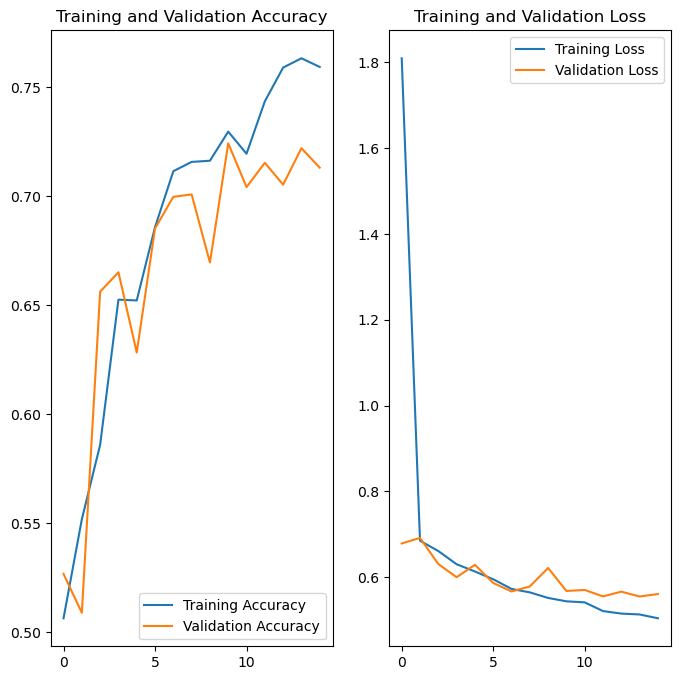

In [32]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# 10
# Compute probability that each test image is a dog or a cat.
import numpy as np

pred = model.predict(test_data_gen,
                     steps= None, # o:  test_data_gen.n//test_data_gen.batch_size
                     max_queue_size=10,   # o quitar este?
                     workers=1, use_multiprocessing=False, verbose=1)

#predicted_class_indices=np.argmax(pred,axis=-1)    # If last layer is > 1
#predicted_class_indices=pred.round()                # If last layer == 0

probabilities = []
for element in pred:
    probabilities.append(element)

# Plot 
sample_test_images, _ = next(test_data_gen)
plotImages(sample_test_images, probabilities=probabilities)


In [48]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if probability.round() == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 72.0% of the images of cats and dogs.
You passed the challenge!
